In [1]:
import numpy as np
import keras
from keras.applications import VGG16
from keras import models, layers, optimizers
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from keras.layers import Dense

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import imgaug as ia
from imgaug import augmenters as iaa
import random
import numpy as np

import boto3

from random import randint
import math
import datetime
import scipy.io
import cv2
import os

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Setup Constants

In [2]:
#### Settings
IMAGE_SHAPE=(150, 150, 3)
MAX_HANDS_TO_DETECT = 10
FLATTENED_DIMENSIONS = MAX_HANDS_TO_DETECT * 4 * 2
LIMIT_DATA = 40
#LIMIT_DATA = -1

NUM_EPOCHS = 10
BATCH_SIZE = 20

PERFORM_AUGMENTATION = False

#PRETRAIN_MODEL = 'conv_base_local'
PRETRAIN_MODEL = 'conv_base_vgg16'
# PRETRAIN_MODEL = None

In [3]:
#### FilePath Information
DATA_DIR = '../data'
img_shape_path = '{}X{}'.format(IMAGE_SHAPE[0], IMAGE_SHAPE[1])
HANDS_DATASET = os.path.join(DATA_DIR, 'fabricated/hands_annotated_dataset', img_shape_path)


IMAGE_TEST_DIR = os.path.join(HANDS_DATASET, 'test')
IMAGE_VALIDATION_DIR = os.path.join(HANDS_DATASET, 'validation')
IMAGE_TRAIN_DIR = os.path.join(HANDS_DATASET, 'training')
SAVED_MODEL_DIR = os.path.join(DATA_DIR, 'models/hands_localization')



### Load in pretrained models

In [4]:
conv_base_local = load_model('../data/models/hands_localization/2018-10-21 17:07:05___15.063819832981867.h5')

In [5]:
conv_base_local.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [6]:
conv_base_vgg16 = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### Load annotations from a specified file

In [7]:
def load_annotations(file):
    return np.load(file)

len(load_annotations('../data/fabricated/hands_annotated_dataset/225X225/test/annotations/VOC2007_10.jpg.npy'))


80

### Pull images/annotations from directory

In [8]:
def load_annotations_from_dir(directory):
    annotations_dir = os.path.join(directory, 'annotations')
    annotation_files = os.listdir(annotations_dir)
    annotations_for_all_files = []
    i = 0
    for annotation_file in annotation_files:
        if LIMIT_DATA > -1 and i == LIMIT_DATA:
            break
        # ignore config files
        if annotation_file.find('.') == 0:
            continue
        annotation_filepath = os.path.join(annotations_dir, annotation_file)
        annotations = load_annotations(annotation_filepath)
        annotations_for_all_files.append(annotations)
        i += 1
    return np.array(annotations_for_all_files)

def load_images_from_dir(directory):    
    images_dir = os.path.join(directory, 'images')
    images = os.listdir(images_dir)

    imgs = [] # TODO: Delete

    i = 0
    for _file in images:
        if LIMIT_DATA > -1 and i == LIMIT_DATA:
            break
        # ignore config files
        if _file.find('.') == 0:
            continue
        filepath = os.path.join(images_dir, _file)
        img = load_img(filepath, target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
        
        img_ORIGINAL = load_img(filepath)
        #imgs.append(img_ORIGINAL)
        imgs.append(img_to_array(img_ORIGINAL))
        i += 1

        
    return np.array(imgs)

### Load images and annotations

In [9]:
def resize_images(images):
    resized_images = []
    for image in images:
        normalized_image = image / 255
        resized_images.append(normalized_image)
    return np.array(resized_images)

In [10]:
def load_images_as_np(directory):
    images_raw = load_images_from_dir(directory)
    x_dataset = resize_images(images_raw)
    y_dataset = load_annotations_from_dir(directory)
                
    return x_dataset, y_dataset

In [11]:
%time x_train, y_train = load_images_as_np(IMAGE_TRAIN_DIR)

CPU times: user 75.2 ms, sys: 21.7 ms, total: 96.9 ms
Wall time: 95.3 ms


In [12]:
%time x_val, y_val = load_images_as_np(IMAGE_VALIDATION_DIR)

CPU times: user 73 ms, sys: 12.1 ms, total: 85.2 ms
Wall time: 84.9 ms


In [13]:
%time x_test, y_test = load_images_as_np(IMAGE_TEST_DIR)

CPU times: user 81.5 ms, sys: 13.1 ms, total: 94.5 ms
Wall time: 94.5 ms


### Visualize the annotations on the images

In [14]:
# takes a list of flat annotations and will turn them into actual polygon shapes (around hands)
def hands_from_flat_annotation(annotation):
    annotation = np.array(annotation)
    return annotation.reshape(MAX_HANDS_TO_DETECT, 4, 2).tolist()
    
def hands_from_flat_annotations(annotations):
    return [hands_from_flat_annotation(annotation) for annotation in annotations]
np.array(hands_from_flat_annotations(y_train)).shape

(40, 10, 4, 2)

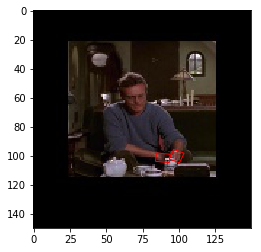

In [15]:
def display_image_with_annotation(img, annotations, ax = plt.gca()):
    plt.imshow(array_to_img(img))
    annotations = hands_from_flat_annotation(annotations)
    for annotation in annotations:
        line = plt.Polygon(annotation, fill=None, edgecolor='r')
        ax.add_patch(line)

first_annotations_from_first_video = y_train[0]
first_image = x_train[0]
display_image_with_annotation(first_image, first_annotations_from_first_video)

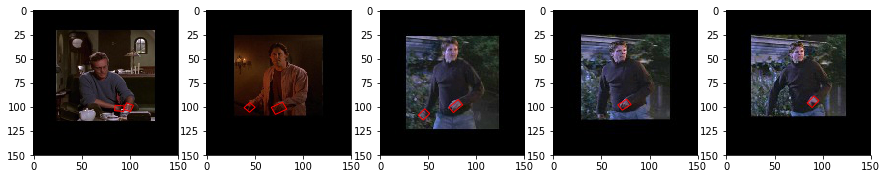

In [16]:
def display_images_with_annotations(imgs, annotations):
    i = 1
    num_rows = 1
    num_cols = len(imgs)
    f = plt.figure(figsize=(15,5))
    for img, annotation in zip(imgs, annotations):
        ax = f.add_subplot(1, num_cols, i)
        display_image_with_annotation(img, annotation, ax)
        i += 1
        

display_images_with_annotations(x_train[:5], y_train[:5])

# Augment Images and Annotations using imgaug

In [17]:
def turn_annotations_into_keypoints(annotations):
    annotations = hands_from_flat_annotations(annotations.copy())
    keypoints_on_images = []
    for hands in annotations:
        keypoints = []
        for hand in hands:
            for point in hand:
                keypoints.append(ia.Keypoint(x=point[0], y=point[1]))
        keypoints_on_images.append(ia.KeypointsOnImage(keypoints, shape=IMAGE_SHAPE))
    return keypoints_on_images

total_number_images_augmented = 0
def augment_images_and_keypoints(images, keypoints_on_images, total_images):
    global total_number_images_augmented
    
    total_number_images_augmented += len(images)
    
    # Should be a number between 0-1, gradually incrementing until we have reached the last epoch
    scale_to_augment_images = total_number_images_augmented / (total_images * NUM_EPOCHS)
    if scale_to_augment_images > 1:
        scale_to_augment_images = 1
    
    si = scale_to_augment_images
    
    scale_diff = .1 # the max that our scaling will be done
    
    image_width = IMAGE_SHAPE[0]
    augmentors = []
    if PERFORM_AUGMENTATION:
        augmentors = [
            #iaa.GaussianBlur((0, 3.0)),
            iaa.Affine(
                scale=(1 - (scale_diff*si), (1 + scale_diff*si)),
                rotate=(-5*si, 5*si),
                shear=(-5*si, 5*si),
                mode='edge'
            ),
            #iaa.Fliplr(.5),
            #iaa.Dropout(.1),
            #iaa.Affine(mode='edge'),
            #iaa.CropAndPad(percent=(-.05, .1)),
            #iaa.Crop(px=(0, 16)),
        ]
    seq = iaa.Sequential(augmentors)
    seq_det = seq.to_deterministic() # call this for each batch again, NOT only once at the start
    images_aug = seq_det.augment_images(images)
    keypoints_aug = seq_det.augment_keypoints(keypoints_on_images)
    return images_aug, keypoints_aug

def keypoints_into_annotations(keypoints_on_images):
    annotations = []
    for keypoints in keypoints_on_images:
        image_annotation = []
        for keypoint in keypoints.keypoints:
            image_annotation.append(keypoint.x)
            image_annotation.append(keypoint.y)
        annotations.append(image_annotation)
    return annotations
        


### Create Generator that will augment data

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 9.06 µs
generator using 40 features
CPU times: user 9.76 ms, sys: 3.02 ms, total: 12.8 ms
Wall time: 10.4 ms
CPU times: user 140 ms, sys: 1.47 ms, total: 142 ms
Wall time: 141 ms
CPU times: user 3.25 ms, sys: 356 µs, total: 3.61 ms
Wall time: 3.27 ms
CPU times: user 66.1 ms, sys: 2.5 ms, total: 68.6 ms
Wall time: 67.4 ms
CPU times: user 3.41 ms, sys: 290 µs, total: 3.7 ms
Wall time: 3.51 ms
CPU times: user 67.2 ms, sys: 2.56 ms, total: 69.8 ms
Wall time: 69.5 ms


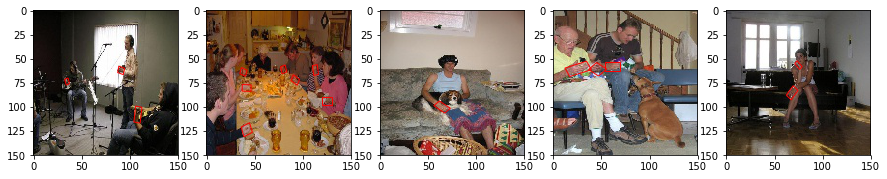

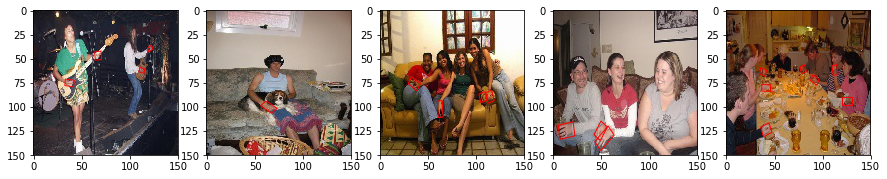

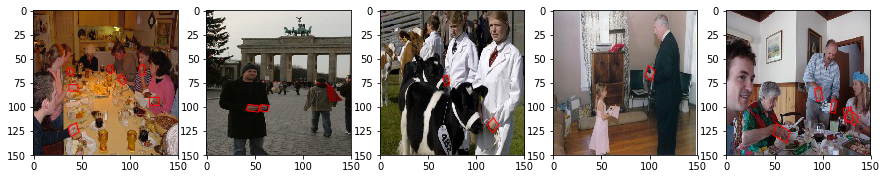

In [18]:
def augmentation_generator(features, labels, batch_size, total_images):
    feature_size = len(features)
    print('generator using {} features'.format(feature_size))
    return_features = features.copy()
    return_labels = turn_annotations_into_keypoints(labels)

    # create empty arrays to contains batch of features and labels
    batch_features = np.zeros((batch_size, IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]))
    batch_labels = np.zeros((batch_size, FLATTENED_DIMENSIONS))	# X and Y coordinates
    
    batches_completed = 0
    
    # randomize the indexes to access features
    # for each batch, increment batches_completed
    # if batches_completed % feature_size == 0, then create a new set of randomized indexes

    while True:
        randomized_indices = np.random.choice(feature_size, feature_size, replace=False)
        
        for i in range(batch_size):
            index = randomized_indices[i]
            

            random_augmented_image, random_augmented_labels = augment_images_and_keypoints([return_features[index]], [return_labels[index]], total_images)
            batch_features[i] = random_augmented_image[0]
            batch_labels[i] = keypoints_into_annotations(random_augmented_labels)[0]

        yield batch_features, batch_labels

        
%time __gen__ = augmentation_generator(x_test, y_test, 10, len(x_test))
%time imgs, labels = next(__gen__)
%time display_images_with_annotations(imgs[:5], labels[:5])
%time imgs, labels = next(__gen__)
%time display_images_with_annotations(imgs[:5], labels[:5])
%time imgs, labels = next(__gen__)
%time display_images_with_annotations(imgs[:5], labels[:5])



### Create Model

In [19]:
# Create new model
conv_base = None

if PRETRAIN_MODEL == 'conv_base_local':
    conv_base = conv_base_local

    # Get input
    new_input = conv_base.input
    # Find the layer to connect
    hidden_layer = conv_base.layers[-4].output
    # Build a new model
    conv_base = Model(new_input, hidden_layer)
if PRETRAIN_MODEL == 'conv_base_vgg16':
    conv_base = conv_base_vgg16

if conv_base is not None:
    conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [20]:
model = None

def create_model_from_base():
    model = models.Sequential()
    model.add(conv_base)

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(FLATTENED_DIMENSIONS)) # linear
    model.compile(optimizer=optimizers.RMSprop(lr=.001), loss='mse', metrics=['mae'])
    return model


def create_model_from_scratch():
    model = models.Sequential()
    model.add(layers.Conv2D(16, (3, 3), activation='relu',
                        input_shape=[IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]]))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    #model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(FLATTENED_DIMENSIONS)) # linear
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

if PRETRAIN_MODEL == 'conv_base_local' or PRETRAIN_MODEL == 'conv_base_vgg16':
    model = create_model_from_base()
else:
    model = create_model_from_scratch()

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 80)                20560     
Total params: 16,832,656
Trainable params: 16,832,656
Non-trainable params: 0
_________________________________________________________________


### Create plot to show MAE and Loss

In [22]:
def plot_mae(history):
    plt.figure()
    mae = history.history['mean_absolute_error']
    val_mae = history.history['val_mean_absolute_error']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(mae))

    plt.plot(epochs, mae, 'bo', label='Training mae')
    plt.plot(epochs, val_mae, 'b', label='Validation mae')
    plt.title('Training and validation mae')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation Loss')
    plt.legend()

    plt.show()

### Create checkpoints

In [23]:
def callback(x, y):
    y_predictions = model.predict([x_test[:5]])
    display_images_with_annotations(x_test[:5], y_predictions[:5])

lambda_callback = keras.callbacks.LambdaCallback(on_epoch_end=callback)

## Train model

generator using 40 features
Epoch 1/10
2/2 [==============================] - 18s 9s/step - loss: 2875596997262.3262 - mean_absolute_error: 872305.9010 - val_loss: 2562.9658 - val_mean_absolute_error: 25.9673
Epoch 2/10
2/2 [==============================] - 17s 8s/step - loss: 1213.4246 - mean_absolute_error: 13.3317 - val_loss: 2144.1973 - val_mean_absolute_error: 26.2957
Epoch 3/10
2/2 [==============================] - 17s 9s/step - loss: 14366.5466 - mean_absolute_error: 64.6359 - val_loss: 2190.7526 - val_mean_absolute_error: 25.7795
Epoch 4/10
2/2 [==============================] - 17s 8s/step - loss: 978.9828 - mean_absolute_error: 14.7860 - val_loss: 2039.8679 - val_mean_absolute_error: 25.4470
Epoch 5/10
2/2 [==============================] - 17s 8s/step - loss: 711.7896 - mean_absolute_error: 14.6939 - val_loss: 2671.9148 - val_mean_absolute_error: 37.2350
Epoch 6/10
2/2 [==============================] - 17s 8s/step - loss: 1012.3961 - mean_absolute_error: 19.8520 - val_los

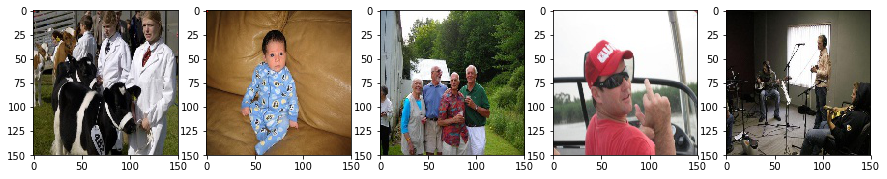

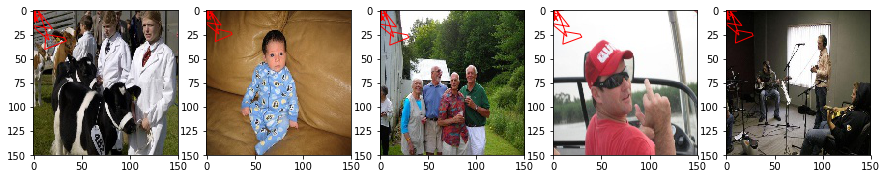

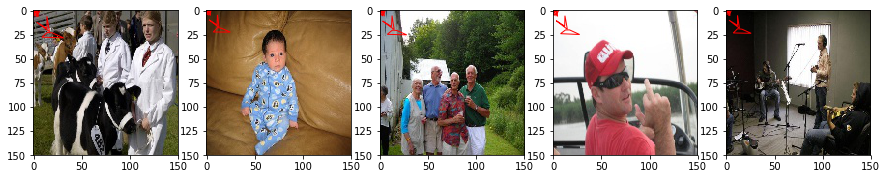

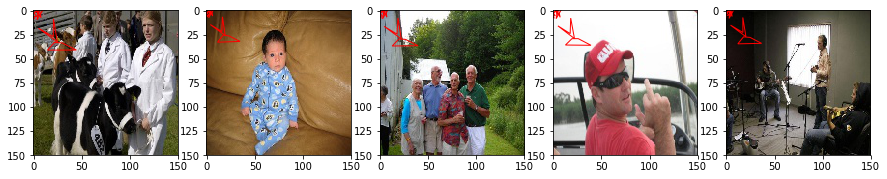

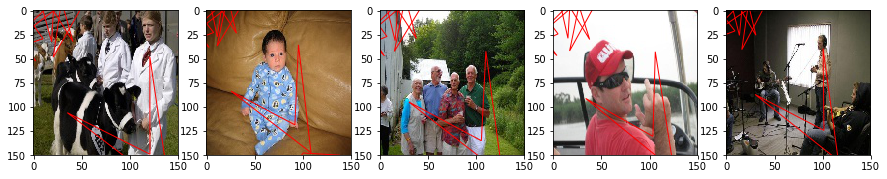

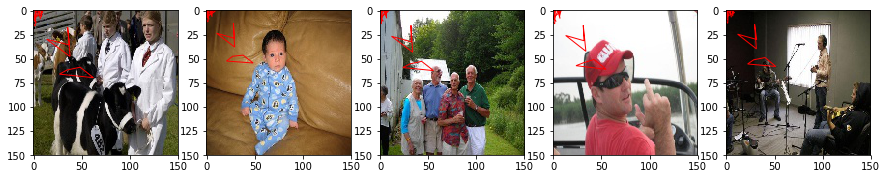

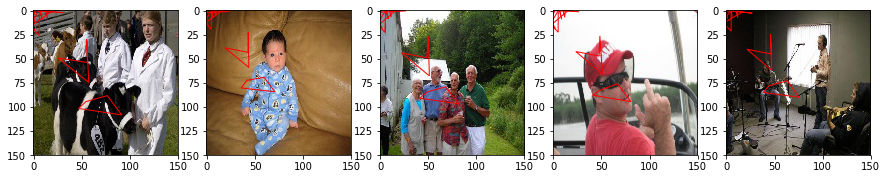

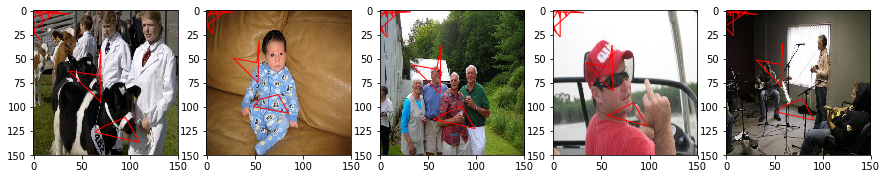

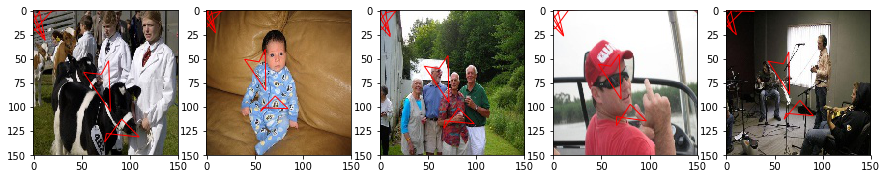

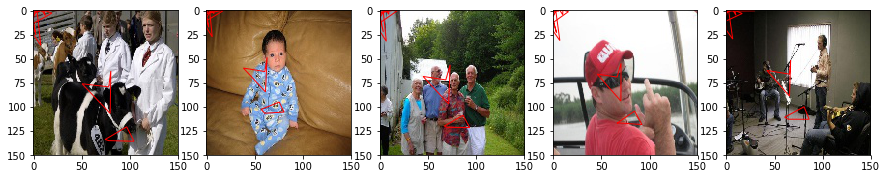

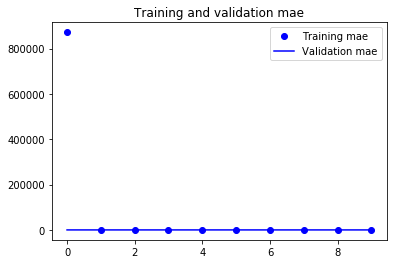

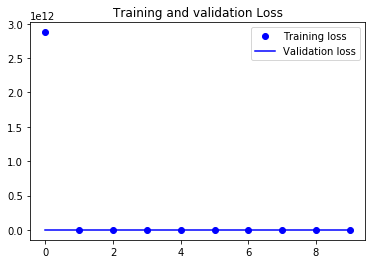

In [24]:
%time history = model.fit_generator(augmentation_generator(x_train, y_train, BATCH_SIZE, len(x_train)), \
                                    epochs=NUM_EPOCHS, \
                                    verbose=1, \
                                    steps_per_epoch = len(x_train) / BATCH_SIZE, \
                                    validation_data=(x_val, y_val), \
                                    callbacks=[lambda_callback])

plot_mae(history)

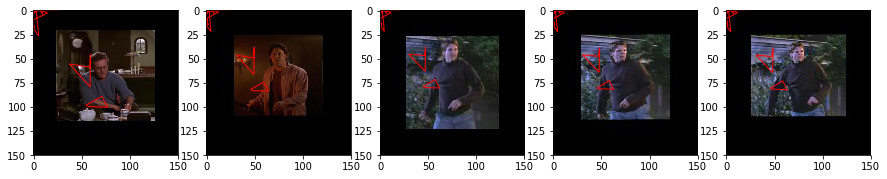

In [25]:
y_predictions = model.predict([x_train[:5]])
display_images_with_annotations(x_train[:5], y_predictions[:5])

### Save model to filesystem

In [26]:
def ensure_model_directory_exists():
    try:
        os.mkdir(SAVED_MODEL_DIR)
    except:
        print('Tried to create "{}" but it already exists'.format(SAVED_MODEL_DIR))

def save_model():
    ensure_model_directory_exists()
    
    evaluate_model_with_test_data = model.evaluate([x_test], y_test)

    accuracy_of_model = evaluate_model_with_test_data[-1]
    timestamp_raw = str(datetime.datetime.now())
    timestamp_without_milliseconds = timestamp_raw.split('.')[0]
    
    model_filename = '{}___{}.h5'.format(timestamp_without_milliseconds, accuracy_of_model)
    model_filepath = os.path.join(SAVED_MODEL_DIR, model_filename)
    
    print('saving file {}'.format(model_filepath))

    model.save(model_filepath)
    return accuracy_of_model
mae = save_model()

Tried to create "../data/models/hands_localization" but it already exists
40/40 [==============================] - 5s 116ms/step
saving file ../data/models/hands_localization/2018-10-28 22:00:38___18.787172698974608.h5


### Call me beep me if you want to reach me

In [27]:
# Send text message when complete (if the environment variable "TEXT_PHONENUMBER" is set)
if 'TEXT_PHONENUMBER' in os.environ:
    text_phonenumber = os.environ['TEXT_PHONENUMBER']
    client = boto3.client('sns')
    client.publish(PhoneNumber=text_phonenumber, Message='Model Finished with mae {}'.format(mae))
    print('text sent')

text sent
